In [3]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

sys.path.append("../")
import covid19_ode_inference as cov19_ode

/home/test/.local/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [5]:
id_func = lambda x: x
remove_beg_end = lambda x: x[1:-1]
data1 = np.loadtxt("example1.csv", skiprows=1, delimiter=",", converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end})
data2 = np.loadtxt("example1_SIR.csv", skiprows=1, delimiter=",")#, converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end})
N=100_000
cases_data = data1[:, 2]
t_cases_data = np.arange(len(cases_data))
seropos_data = data2[:, 3]/N
t_seropos_data = np.array([1,75,180])
seropos_data_subs = seropos_data[t_seropos_data]
len_sim = len(cases_data)
time=t_cases_data

In [6]:
model = cov19_ode.examples.model_cases_seropositivity(
    N,
    cases_data,
    t_cases_data,
    seropos_data_subs,
    t_seropos_data=t_seropos_data,
    sim_model=False,
    fact_subs=8,
    num_cps_reporting=6,
    num_cps_R = 6,
)

/home/test/.local/lib/python3.11/site-packages/pymc/distributions/bound.py:185: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode="JAX")
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode="JAX")
dlogp_fn(ip)
print("Timing JAX compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode='FAST_RUN')
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode='FAST_RUN')
dlogp_fn(ip)
print("Timing C compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)
;

Timing JAX compiled:
178 µs ± 667 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
242 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Timing C compiled:
270 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
603 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


''

In [8]:
def get_initial_random_points(num_chains, model):
    num_tries = 1000
    init = pm.sample_prior_predictive(num_tries , model=model, return_inferencedata=True)
    points_with_nan = np.unique(np.argwhere(np.isnan(np.array(init.prior_predictive["new_reported_data"])))[:,1])
    print(f"Percentage of initial_points with nans: {len(points_with_nan)/num_tries:.0%}")
    init_dict = []
    for chain in range(num_tries):
        if chain not in points_with_nan:
            init_dict.append({key: np.array(val)[0, chain] for (key, val) in init.prior.items() })
        if len(init_dict) == num_chains:
            break
    else: 
        raise RuntimeError("Not enough initial points without nans")
    return init_dict
get_initial_random_points(4, model = cov19_ode.examples.model_cases_seropositivity(
    N,
    cases_data,
    t_cases_data,
    seropos_data_subs,
    t_seropos_data=t_seropos_data,
    sim_model=False,
    fact_subs=8,
    num_cps_reporting=6,
    num_cps_R = 6,
    truncater = pm.Truncated,
))

Sampling: [Delta_rhos_R_raw, Delta_rhos_raw, Delta_t_pos_R, Delta_t_pos_rep, R0, error_report, error_sero, eta_base, frac_R_0, frac_S_0, inv_gamma, new_reported_data, sero_data, sigma_Delta_rhos, sigma_Delta_rhos_R, transients_R_raw, transients_rep_raw]


Percentage of initial_points with nans: 73%


[{'gamma': 0.06264029636379626,
  't_pos_rep': array([ 30.50081347,  60.5763676 ,  94.19442787, 112.1042126 ,
         145.89802796, 161.08722188]),
  'transients_rep_raw': array([ 6.98537094,  7.31654454, 23.41763932,  5.29805087,  6.25679855,
          8.92099151]),
  'eta_base': 0.2974086070737618,
  'R': array([ 113.13251826,  547.07705887,  992.97993068, 1429.15950188,
         1827.60230544, 2163.45324791, 2425.22639652, 2616.40574891,
         2749.13134084, 2837.57054572, 2894.52338446, 2930.28188056,
         2952.39353759, 2965.96464516, 2974.26802405, 2979.34358595,
         2982.44689118, 2984.34635152, 2985.51090638, 2986.22630414,
         2986.66659905, 2986.93793546, 2987.10523369, 2987.20835624,
         2987.27186682, 2987.31093573, 2987.3349387 , 2987.34966744]),
  'I_0': 844.2438825246209,
  'inv_gamma': 15.964164572151715,
  'sigma_Delta_rhos': 0.8401925849342365,
  'I': array([8.44243883e+02, 8.83329940e+02, 8.88639654e+02, 8.42404682e+02,
         7.39522127e+02,

In [11]:
num_chains = 6

# init_dict = get_initial_random_points(num_chains)
init_dict = get_initial_random_points(num_chains, model = cov19_ode.examples.model_cases_seropositivity(
    N,
    cases_data,
    t_cases_data,
    seropos_data_subs,
    t_seropos_data=t_seropos_data,
    sim_model=False,
    fact_subs=8,
    num_cps_reporting=6,
    num_cps_R = 6,
    truncater = pm.Truncated,
))

idata_gen = cov19_ode.custom_sample.my_sample(
# idata_gen = pm.sample(
    model=model,
    tune=500,
    draws=1000,
    cores=num_chains,
    discard_tuned_samples=False,
    nuts_sampler="mynumpyro",
    target_accept=0.9,
    initvals=init_dict,
    nuts_sampler_kwargs=dict(
        chain_method="parallel", 
        nuts_kwargs=dict(max_tree_depth=10, 
                         step_size=1,)
    ),
    idata_kwargs=dict(
        save_warmup=True,
    ),
    keep_warning_stat=True,
)
warnings = pm.stats.convergence.run_convergence_checks(idata_gen,model=model,)
pm.stats.convergence.log_warnings(warnings) 

Sampling: [Delta_rhos_R_raw, Delta_rhos_raw, Delta_t_pos_R, Delta_t_pos_rep, R0, error_report, error_sero, eta_base, frac_R_0, frac_S_0, inv_gamma, new_reported_data, sero_data, sigma_Delta_rhos, sigma_Delta_rhos_R, transients_R_raw, transients_rep_raw]


Percentage of initial_points with nans: 70%


/home/test/covid19_ode_inference2/notebooks/../covid19_ode_inference/custom_sample.py:280: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:17.920160
Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampling time =  0:03:00.139056
Transforming variables...
Transformation time =  0:00:00.728202
{'save_warmup': True}


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 408 divergences after tuning. Increase `target_accept` or reparameterize.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


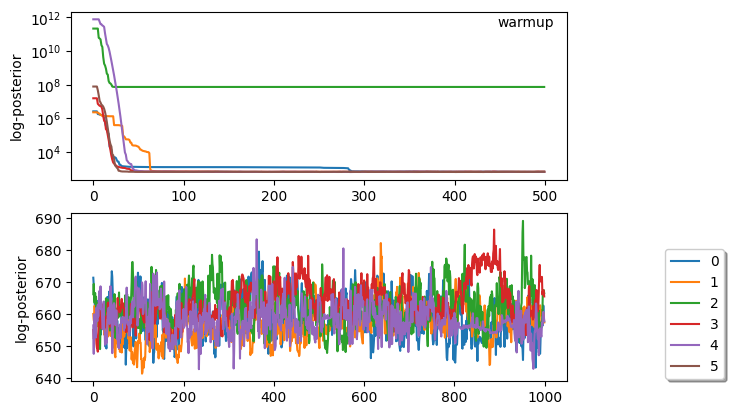

In [106]:
chainsel=[0,1,2,3,4,5]
chainsel=[0,1,3,4,5]

# fig, ax = plt.subplots(3, sharex=True, sharey=True)
fig, ax = plt.subplots(2)
def my_get_subplot(i):
    return ax[i]
ax_warmup = my_get_subplot(0).plot(idata_gen.warmup_sample_stats["lp"].T)
my_get_subplot(0).set_ylabel("log-posterior");
my_get_subplot(0).set_yscale("log")
fig.legend(title="warmup", loc='right', bbox_to_anchor=(0.9,0.85),shadow=False,frameon=False);
for i in range(len(ax_warmup)):
    ax_warmup[i].set_color("C"+str(i))

idata = idata_gen.sel(chain=chainsel, groups="posterior_groups")

ax_sample = my_get_subplot(1).plot(idata.sample_stats["lp"].T)
my_get_subplot(1).set_ylabel("log-posterior");
# my_get_subplot(1).set_ylim((640,680))
# my_get_subplot(0).set_legend(np.arange(0,6));
for i in range(len(ax_sample)):
    ax_sample[i].set_color("C"+str(i))

fig.legend(np.arange(0,6), loc='lower center', bbox_to_anchor=(1.1, 0.1),
          fancybox=True, shadow=True, ncol=1);

In [ ]:
chainsel=[0,1,2,3,4,5]
# clrs = np.array(list(map(lambda x:"C"+str(x),chainsel)))
idata = idata_gen.sel(chain=chainsel, groups="posterior_groups")
ax = plt.plot(idata.sample_stats["lp"].T)#,color=clrs)
for i in range(len(ax)):
    ax[i].set_color("C"+str(chainsel[i]))
plt.ylabel("log-posterior");
plt.legend(chainsel);

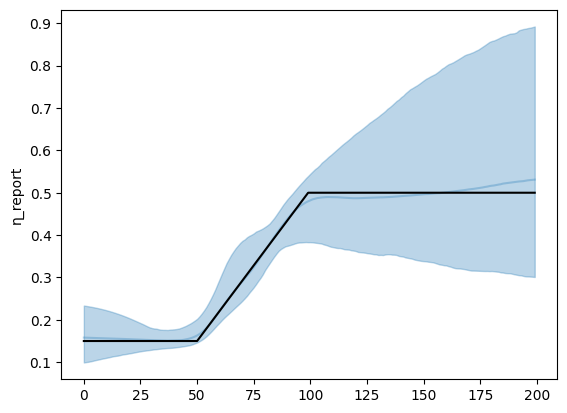

In [108]:
values_inferred = idata.posterior["eta_report"].to_numpy().reshape((-1, len_sim))

plt.plot(time, np.median(values_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(values_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(data1[:, 2]/data1[:, 1], color="black")
plt.ylabel("η_report");

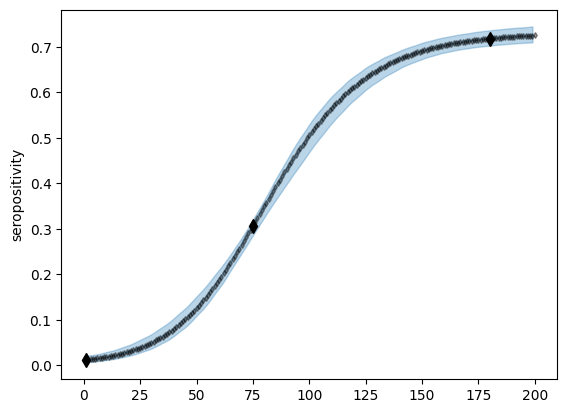

In [109]:
new_positive_inferred = idata.posterior["Sero_t"].to_numpy().reshape((-1, len_sim))

plt.fill_between(time, *np.percentile(new_positive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(time, np.median(new_positive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.plot(seropos_data, marker="d", color="black", ls="", ms=3, alpha=0.4);
plt.plot(t_seropos_data, seropos_data[t_seropos_data], marker="d", color="black", ls="", ms=7);
plt.ylabel("seropositivity");


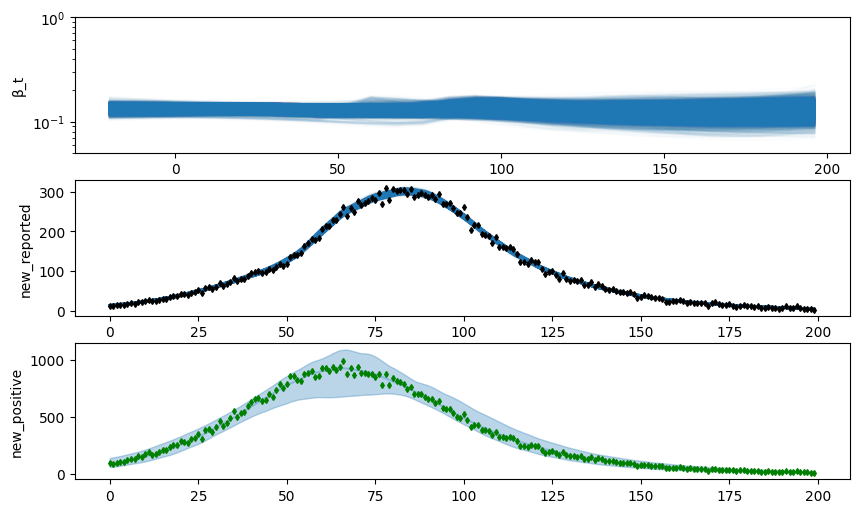

In [110]:
f, axes = plt.subplots(3,1, figsize = (10,6))
t_solve_ODE = model.coords["t_solve_ODE"]

f.sca(axes[0])
plt.plot(t_solve_ODE, idata.posterior["beta_t"].to_numpy().reshape((-1, len(t_solve_ODE))).T, color="tab:blue", alpha = 0.02);
plt.ylabel("β_t")
plt.ylim((0.05,1))
plt.yscale("log")

f.sca(axes[1])
plt.plot(idata.posterior["new_reported"].to_numpy().reshape((-1, len_sim)).T, color="tab:blue", alpha = 0.02);
plt.plot(cases_data, marker="d", color="black", ls="", ms=3);
plt.ylabel("new_reported")

f.sca(axes[2])
new_positive_inferred = idata.posterior["new_positive"].to_numpy().reshape((-1, len_sim))
plt.plot(time, np.median(new_positive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(new_positive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(data1[:, 1], marker="d", color="green", ls="", ms=3);
#plt.plot(cases_data, marker="d", color="black", ls="", ms=3);
plt.ylabel("new_positive");


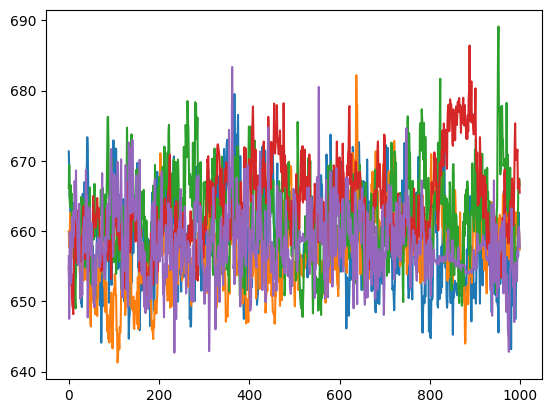

In [111]:
plt.plot(idata.sample_stats["lp"].T);

<xarray.DataArray 'tree_depth' (chain: 5)>
array([ 9.755, 10.   ,  9.915, 10.   ,  9.23 ])
Coordinates:
  * chain    (chain) int64 0 1 3 4 5

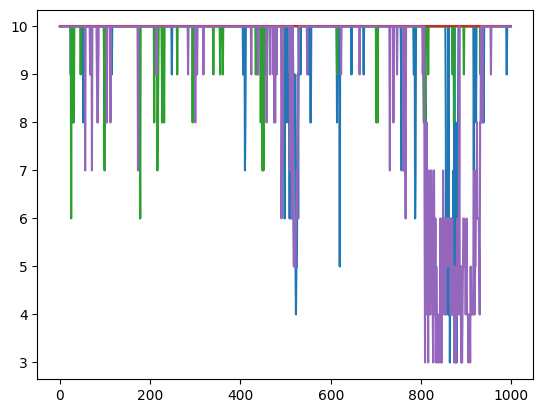

In [112]:
plt.plot(idata.sample_stats["tree_depth"].T);
np.mean(idata.sample_stats["tree_depth"], axis=1)

In [114]:
import arviz as az
rhat = az.rhat(idata)
rhat.max()

<xarray.Dataset>
Dimensions:             ()
Data variables: (12/31)
    eta_base            float64 1.209
    Delta_t_pos_rep     float64 1.494
    Delta_rhos_raw      float64 1.797
    transients_rep_raw  float64 1.404
    Delta_t_pos_R       float64 1.22
    Delta_rhos_R_raw    float64 1.307
    ...                  ...
    S                   float64 1.28
    I                   float64 1.26
    R                   float64 1.245
    new_positive        float64 1.41
    new_reported        float64 1.082
    Sero_t              float64 1.25